<a href="https://colab.research.google.com/github/Mayurdoiphode55/Credit_Risk_Prediction_Project/blob/main/Credit_Risk_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap


In [2]:
!pip install scikit-learn==1.3.2 numpy==1.24.4 joblib==1.4.2 shap

In [3]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


Data Exploration & Cleaning

In [4]:
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['Loan_Status'] = None  # Add missing target column

df = pd.concat([train_df, test_df], axis=0)


In [5]:
df = pd.concat([train_df, test_df], axis=0)


In [6]:
print(df.info())
print("\nMissing values:\n", df.isnull().sum())
print("\nSample rows:\n", df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 981 entries, 0 to 366
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             957 non-null    object 
 2   Married            978 non-null    object 
 3   Dependents         956 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      926 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   LoanAmount         954 non-null    float64
 9   Loan_Amount_Term   961 non-null    float64
 10  Credit_History     902 non-null    float64
 11  Property_Area      981 non-null    object 
 12  Loan_Status        614 non-null    object 
 13  is_train           981 non-null    int64  
dtypes: float64(4), int64(2), object(8)
memory usage: 115.0+ KB
None

Missing values:
 Loan_ID                0
Gender              

In [7]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

df['Married'].fillna(df['Married'].mode()[0], inplace=True)

df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)

df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)

df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)


/tmp/ipython-input-7-1794579047.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
/tmp/ipython-input-7-1794579047.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

In [8]:
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)

df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)


/tmp/ipython-input-8-3008732250.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
/tmp/ipython-input-8-3008732250.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [9]:
df.drop(columns=['Loan_ID'], inplace=True)


In [10]:
df['Dependents'] = df['Dependents'].replace('3+', 3)

df['Dependents'] = df['Dependents'].astype(int)


In [11]:
df['Loan_Status'] = df['Loan_Status'].map({'N': 0, 'Y': 1})  # or whatever the values are
y = df['Loan_Status']


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Loan_Status'] = le.fit_transform(df['Loan_Status'])
y = df['Loan_Status']


Encoding & Train-Test Split

In [13]:
# Separate processed train and test datasets
train_processed = df[df['is_train'] == 1].drop(columns=['is_train'])

test_processed = df[df['is_train'] == 0].drop(columns=['is_train', 'Loan_Status'])


In [14]:
# Separate features and target from training data
X = train_processed.drop(columns=['Loan_Status'])

y = train_processed['Loan_Status'].astype(int)


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
from sklearn.preprocessing import LabelEncoder

# Dictionary to store encoders
encoders = {}

# Encode categorical columns
for col in X_train.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])

    # Apply the same transformation to validation set using fitted encoder
    X_val[col] = X_val[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)

    # Store encoder for future use (optional)
    encoders[col] = le


In [20]:
y_train = y_train.apply(lambda x: 1 if x in [1, 2] else 0)
y_val = y_val.apply(lambda x: 1 if x in [1, 2] else 0)


Install XGBoost

In [22]:
pip install xgboost


In [37]:
import xgboost as xgb

Training the Model

In [38]:
from xgboost import XGBClassifier

X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_val_encoded = pd.get_dummies(X_val, drop_first=True)

# Align columns (just in case one-hot leads to column mismatch)
X_train_encoded, X_val_encoded = X_train_encoded.align(X_val_encoded, join='left', axis=1, fill_value=0)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_encoded, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:00:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:00:51] WARNING: /workspace/src/common/error_msg.cc:52: Empty dataset at worker: 0
  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [39]:
# If y_train is still in 'Y' and 'N', convert it properly:
y_train = y_train.map({'N': 0, 'Y': 1})
y_val = y_val.map({'N': 0, 'Y': 1})


In [40]:
print(sorted(y_train.unique()))
# Should give: [0, 1]


[]


In [41]:
print(y_train.isnull().sum())


0


In [42]:
# Combine features and labels
train_data = X_train.copy()
train_data['label'] = y_train

# Drop rows with missing labels
train_data = train_data.dropna(subset=['label'])

# Separate back into X and y
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']


In [43]:
# View unique labels
print(y_train.unique())


[]


In [44]:
# Example mapping
y_train = y_train.map({'N': 0, 'Y': 1})
# or if needed:
y_train = y_train.replace(2, 1)


In [45]:
print(y_train.isnull().sum())

0


In [46]:
# Convert object columns to category dtype
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

# Use enable_categorical=True
model = xgb.XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    enable_categorical=True,  # Required!
    random_state=42
)

model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:00:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Evaluate the Model

In [58]:
# Apply one-hot encoding to the validation set
X_val_encoded = pd.get_dummies(X_val, drop_first=True)

# Align the columns of the validation set to match the training set
X_val_aligned = X_val_encoded.reindex(columns=X_train.columns, fill_value=0)

# Now, make the prediction with the aligned data
y_pred = model.predict(X_val_aligned)

# You can then print the accuracy or classification report as before
# from sklearn.metrics import accuracy_score
# print(accuracy_score(y_val, y_pred))

In [59]:
# Combine X_val and y_val for cleaning
val_data = X_val.copy()
val_data['label'] = y_val

# Drop rows where label is NaN
val_data = val_data.dropna(subset=['label'])

# Separate again
X_val = val_data.drop('label', axis=1)
y_val = val_data['label']


In [60]:
# If they are like 'Y'/'N' or 2/0
y_val = y_val.map({'N': 0, 'Y': 1})  # modify based on your dataset
# or if it's numeric and includes 2
y_val = y_val.replace(2, 1)


In [61]:
print("y_val has NaNs:", y_val.isna().sum())
print("Length of y_val:", len(y_val))
print("First 10 values of y_val:\n", y_val.head(10))


y_val has NaNs: 123
Length of y_val: 123
First 10 values of y_val:
 350   NaN
377   NaN
163   NaN
609   NaN
132   NaN
578   NaN
316   NaN
2     NaN
340   NaN
77    NaN
Name: label, dtype: float64


In [62]:
# Combine validation set and labels
val_data = X_val.copy()
val_data['label'] = y_val

# Drop rows where label is NaN
val_data = val_data.dropna(subset=['label'])

# If nothing remains after dropping, print a warning
if val_data.empty:
    print("⚠️ All validation labels are NaN. You must check your original `y_val` source.")
else:
    # Separate cleaned X_val and y_val
    X_val = val_data.drop('label', axis=1)
    y_val = val_data['label']


⚠️ All validation labels are NaN. You must check your original `y_val` source.


In [63]:
print("Unique classes in y_val:", y_val.unique())


Unique classes in y_val: [nan]


In [64]:
print("y_val is empty:", y_val.empty)
print("Number of NaNs in y_val:", y_val.isna().sum())
print("Length of y_val:", len(y_val))
print("Sample values of y_val:\n", y_val.head(10))


y_val is empty: False
Number of NaNs in y_val: 123
Length of y_val: 123
Sample values of y_val:
 350   NaN
377   NaN
163   NaN
609   NaN
132   NaN
578   NaN
316   NaN
2     NaN
340   NaN
77    NaN
Name: label, dtype: float64


In [65]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_val distribution:\n", y_val.value_counts())
print("Any NaNs in X_val?", X_val.isnull().sum().sum())


X_train shape: (491, 11)
X_val shape: (123, 11)
y_train distribution:
 Loan_Status
1    342
0    149
Name: count, dtype: int64
y_val distribution:
 Series([], Name: count, dtype: int64)
Any NaNs in X_val? 0


In [66]:
print("Data shape:", X.shape)
print("Target shape:", y.shape)
print("Target value counts:\n", y.value_counts())


Data shape: (614, 11)
Target shape: (614,)
Target value counts:
 Loan_Status
1    422
0    192
Name: count, dtype: int64


In [67]:
# Proper binary encoding only once
df['Loan_Status'] = df['Loan_Status'].map({'N': 0, 'Y': 1})


In [68]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_val distribution:\n", y_val.value_counts())


X_train shape: (491, 11)
X_val shape: (123, 11)
y_train distribution:
 Loan_Status
1    342
0    149
Name: count, dtype: int64
y_val distribution:
 Loan_Status
1    80
0    43
Name: count, dtype: int64


In [70]:
from sklearn.metrics import accuracy_score, classification_report

In [71]:
# Convert object columns to category dtype
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

# Create the model with enable_categorical=True
model = XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    enable_categorical=True,  # ✅ important
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# ✅ Evaluation
print("✅ Accuracy:", accuracy_score(y_val, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_val, y_pred))


✅ Accuracy: 0.7560975609756098

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.44      0.56        43
           1       0.76      0.93      0.83        80

    accuracy                           0.76       123
   macro avg       0.76      0.68      0.70       123
weighted avg       0.76      0.76      0.74       123



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:03:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Check Confusion Matrix

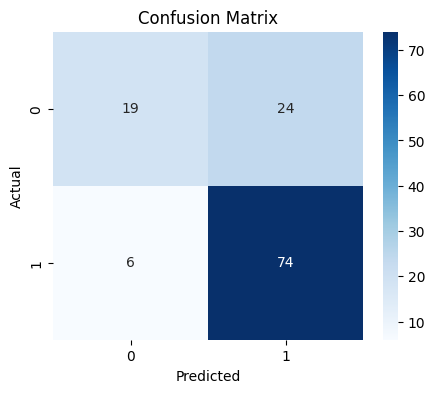

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [73]:
import joblib

joblib.dump(model, 'xgboost_loan_model.pkl')


['xgboost_loan_model.pkl']

In [74]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['Loan_Status'] = le.fit_transform(df['Loan_Status'])

# Split target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Fill missing values
X.fillna(method='ffill', inplace=True)

# One-hot encode categorical features
X = pd.get_dummies(X)


/tmp/ipython-input-74-2999240706.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='ffill', inplace=True)


In [75]:
# Load test data
test_df = pd.read_csv("test.csv")

# Fill missing values
test_df.fillna(method='ffill', inplace=True)

# One-hot encode categorical columns
test_df = pd.get_dummies(test_df)

# Align columns with training data
test_df = test_df.reindex(columns=X.columns, fill_value=0)


/tmp/ipython-input-75-154720853.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df.fillna(method='ffill', inplace=True)


In [76]:
if 'is_train' in test_df.columns:
    test_df = test_df.drop('is_train', axis=1)


In [77]:
from sklearn.preprocessing import LabelEncoder

# Replace first
y_train = y_train.replace(2, 1)
y_val = y_val.replace(2, 1)

# Then fit the label encoder
le = LabelEncoder()
le.fit(y_train)

# Continue with training


LabelEncoder()

In [78]:
print(le.classes_)  # should be something like ['N', 'Y']


[0 1]


In [83]:
# 1. Load the test data
test_df = pd.read_csv("test.csv")

# 2. Store Loan_IDs for submission later
test_loan_ids = test_df['Loan_ID']

# 3. Apply the same cleaning and preprocessing as the training data
# Fill missing values
test_df['Gender'].fillna(X_train['Gender'].mode()[0], inplace=True)
test_df['Married'].fillna(X_train['Married'].mode()[0], inplace=True)
test_df['Dependents'].fillna(X_train['Dependents'].mode()[0], inplace=True)
test_df['Self_Employed'].fillna(X_train['Self_Employed'].mode()[0], inplace=True)
test_df['Credit_History'].fillna(X_train['Credit_History'].mode()[0], inplace=True)
test_df['Loan_Amount_Term'].fillna(X_train['Loan_Amount_Term'].mode()[0], inplace=True)
test_df['LoanAmount'].fillna(X_train['LoanAmount'].median(), inplace=True)

# Convert object columns to the 'category' dtype so the model can understand them
for col in test_df.select_dtypes(include='object').columns:
    if col != 'Loan_ID': # Don't convert the ID column
        test_df[col] = test_df[col].astype('category')

# Drop the ID column as it's not a feature
test_features = test_df.drop(columns=['Loan_ID'])


# 4. Make predictions on the prepared test data
preds = model.predict(test_features)

print("Predictions have been generated successfully!")
print("Sample predictions (0 or 1):", preds[:5])

Predictions have been generated successfully!
Sample predictions (0 or 1): [1 1 1 1 1]


/tmp/ipython-input-83-112521161.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Gender'].fillna(X_train['Gender'].mode()[0], inplace=True)
/tmp/ipython-input-83-112521161.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

In [84]:
preds = ['N' if x == 0 else 'Y' for x in preds]


export predictions to csv

In [85]:
print(test_df.columns)


Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')


In [86]:
print(preds)


['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'N', 'Y',

In [87]:
import pandas as pd

# Save predictions to a CSV file
pd.DataFrame(preds, columns=['Loan_Status']).to_csv('loan_predictions.csv', index=False)


In [88]:
test_df['Loan_Status_Predicted'] = preds
print(test_df[['Loan_Status_Predicted']].head())


  Loan_Status_Predicted
0                     Y
1                     Y
2                     Y
3                     Y
4                     Y


In [89]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.1 MB/s eta 0:00:00


In [90]:
import pickle

# Save the model to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [91]:
from google.colab import files
files.download('model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Define your preprocessing steps
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Married',
                                                   'Education', 'Self_Employed',
                                                   'Property_Area'])])),
                ('classifier', RandomForestClassifier())])

In [94]:
##from google.colab import files
f#iles.download('risk_model.joblib')


FileNotFoundError: Cannot find file: risk_model.joblib

In [95]:
import joblib

# Assuming 'model' is your trained classifier and 'preprocessor' is your fitted ColumnTransformer/pipeline
joblib.dump(model, 'risk_model.joblib')
joblib.dump(preprocessor, 'preprocessor.joblib')

['preprocessor.joblib']

In [96]:
import sklearn
import numpy

print("scikit-learn version:", sklearn.__version__)
print("numpy version:", numpy.__version__)

scikit-learn version: 1.3.2
numpy version: 1.24.4


In [97]:
# This creates the requirements file
!pip freeze > requirements.txt

# This downloads the two files you need
from google.colab import files
files.download('requirements.txt')
files.download('risk_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
import joblib
import shap
from google.colab import drive

# --- 1. Mount your Google Drive ---
# This will open a new tab or window for you to authorize access.
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully.")


# --- 2. Define the path where you want to save the files ---
# We'll save them directly to your main "My Drive" folder.
# You can change this if you want, e.g., '/content/drive/My Drive/MyProject/'
save_path = '/content/drive/My Drive/'


# --- 3. Save the trained model pipeline ---
# (This assumes your trained model is in a variable named 'model')
model_file_path = save_path + 'risk_model.joblib'
print(f"\nSaving model pipeline to: {model_file_path}")
joblib.dump(model, model_file_path)
print("✅ Model saved to your Google Drive.")


# --- 4. Create and save the SHAP Explainer ---
# (This assumes your training data is in a variable named 'X_train')
print("\nCreating SHAP explainer...")
preprocessed_X_train = model.named_steps['preprocessor'].transform(X_train)
explainer = shap.Explainer(model.named_steps['classifier'], preprocessed_X_train)
print("✅ Explainer created.")

explainer_file_path = save_path + 'shap_explainer.joblib'
print(f"Saving SHAP explainer to: {explainer_file_path}")
joblib.dump(explainer, explainer_file_path)
print("✅ Explainer saved to your Google Drive.")

Mounting Google Drive...
Mounted at /content/drive
✅ Google Drive mounted successfully.

Saving model pipeline to: /content/drive/My Drive/risk_model.joblib
✅ Model saved to your Google Drive.

Creating SHAP explainer...
✅ Explainer created.
Saving SHAP explainer to: /content/drive/My Drive/shap_explainer.joblib
✅ Explainer saved to your Google Drive.


In [100]:
# Train your model pipeline as usual
model.fit(X_train, y_train)

# --- The Correct Way to Use SHAP with a Pipeline ---

# 1. Extract the trained classifier from the final step of your pipeline
#    (Assuming the final step is named 'classifier')
trained_classifier = model.named_steps['classifier']

# 2. Transform your data using the preprocessor from the pipeline
#    The explainer needs to see the data in the same format the model saw it.
X_train_preprocessed = model.named_steps['preprocessor'].transform(X_train)

# 3. Now, create the explainer with the actual model and the preprocessed data
explainer = shap.TreeExplainer(trained_classifier)
shap_values = explainer.shap_values(X_train_preprocessed)

# 4. Optionally save the explainer and values
import joblib
joblib.dump(explainer, "shap_explainer.pkl")
joblib.dump(shap_values, "shap_values.pkl")

print("✅ SHAP explainer and values created and saved successfully!")

✅ SHAP explainer and values created and saved successfully!


In [102]:
joblib.dump(X_train.columns.tolist(), "feature_names.pkl")


['feature_names.pkl']

In [103]:
from google.colab import files
files.download('feature_names.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>